In [1]:
import pandas
columns = ['ORDER_ID','TOKEN_ID','ORTH','LEMMA','POS','CTAG','LABEL']
test_raw = pandas.read_csv('kpwr-time_TEST.txt',index_col=False, sep = '\t', names=columns)
train_raw = pandas.read_csv('kpwr-time_TRAIN.txt',index_col=False, sep = '\t', names=columns)
print(train_raw.iloc[0])

ORDER_ID                 0
TOKEN_ID                 0
ORTH             RoboRally
LEMMA            roborally
POS                  subst
CTAG        subst:sg:nom:n
LABEL                    O
Name: 0, dtype: object


In [2]:
print(f'count before dropping nulls : train - {train_raw.shape[0]}, test - {test_raw.shape[0]}')

train_raw = train_raw.dropna()
test_raw = test_raw.dropna()

print(f'count before dropping nulls : train - {train_raw.shape[0]}, test - {test_raw.shape[0]}')
print(f"Unique labels : {train_raw['LABEL'].unique()}")

count before dropping nulls : train - 363366, test - 87032
count before dropping nulls : train - 362104, test - 86560
Unique labels : ['O' 't3_duration-B' 't3_date-B' 't3_duration-I' 't3_set-B' 't3_date-I'
 't3_time-B' 't3_time-I' 't3_set-I']


In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np

tokenizable_columns = ['ORTH','LEMMA','POS','CTAG','LABEL']
for column in tokenizable_columns:
    train_raw[column] = train_raw[column].astype(str)
    test_raw[column] = test_raw[column].astype(str)

In [5]:
for column in ['ORTH','LEMMA','POS','LABEL']:
    train_raw[column] = train_raw[column].replace(':','XX_SEMICOLON_XX')
    test_raw[column] = test_raw[column].replace(':','XX_SEMICOLON_XX')

In [6]:
train = train_raw.copy()
test = test_raw.copy()
for column in tokenizable_columns:
    token_list = train_raw[column].values.tolist()
    token_list.extend(test_raw[column].values.tolist())
    token_count = len(train_raw[column].unique()) + len(test_raw[column].unique()) + 1
    tokenizer = Tokenizer(num_words=token_count, filters = '', split=':')
    tokenizer.fit_on_texts(token_list)
    train[column] = tokenizer.texts_to_sequences(train_raw[column])
    test[column] = tokenizer.texts_to_sequences(test_raw[column])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train.iloc[0:7])
print(test.iloc[0:7])

   ORDER_ID  TOKEN_ID     ORTH    LEMMA   POS               CTAG LABEL
0         0         0  [28848]  [16623]   [1]      [2, 1, 7, 13]   [1]
1         1         1     [40]     [50]   [6]               [22]   [1]
2         2         2   [2328]    [116]   [3]  [10, 1, 7, 13, 9]   [1]
3         3         3   [2067]   [1266]   [1]      [2, 1, 7, 13]   [1]
4         4         4     [20]     [25]   [2]                [4]   [1]
5         5         0    [344]    [499]  [15]               [34]   [1]
6         6         1      [9]     [10]   [6]               [22]   [1]
   ORDER_ID  TOKEN_ID     ORTH    LEMMA  POS            CTAG LABEL
0    363366         0      [6]      [7]  [4]        [11, 14]   [1]
1    363367         1    [309]    [199]  [1]  [2, 1, 14, 13]   [1]
2    363368         2     [17]     [20]  [4]        [11, 14]   [1]
3    363369         3     [13]     [13]  [1]  [2, 1, 14, 13]   [1]
4    363370         4    [663]    [229]  [1]  [2, 1, 14, 13]   [1]
5    363371         5  [57277]

In [7]:
from keras.preprocessing.sequence import pad_sequences

train_columns = ['ORDER_ID','ORTH','LEMMA','POS','CTAG','LABEL']

x_train = train.copy()[train_columns]
x_test = test.copy()[train_columns]

ctag_count = 6

x_train['CTAG'] = pandas.Series(pad_sequences(train['CTAG'],padding='post',  maxlen=ctag_count).tolist())
x_test['CTAG'] = pandas.Series(pad_sequences(test['CTAG'],padding='post',  maxlen=ctag_count).tolist())

In [8]:
for c in ['ORTH','LEMMA','POS']:
    x_train[c] =  x_train[c].apply(lambda a : a[0] if isinstance(a,list) else a)
    x_test[c] =  x_test[c].apply(lambda a : a[0] if isinstance(a,list) else a)
print(x_train[0:5])


   ORDER_ID   ORTH  LEMMA  POS                  CTAG LABEL
0         0  28848  16623    1   [2, 1, 7, 13, 0, 0]   [1]
1         1     40     50    6   [22, 0, 0, 0, 0, 0]   [1]
2         2   2328    116    3  [10, 1, 7, 13, 9, 0]   [1]
3         3   2067   1266    1   [2, 1, 7, 13, 0, 0]   [1]
4         4     20     25    2    [4, 0, 0, 0, 0, 0]   [1]


In [9]:

print(x_train[0:5])
print(x_test[0:5])

   ORDER_ID   ORTH  LEMMA  POS                  CTAG LABEL
0         0  28848  16623    1   [2, 1, 7, 13, 0, 0]   [1]
1         1     40     50    6   [22, 0, 0, 0, 0, 0]   [1]
2         2   2328    116    3  [10, 1, 7, 13, 9, 0]   [1]
3         3   2067   1266    1   [2, 1, 7, 13, 0, 0]   [1]
4         4     20     25    2    [4, 0, 0, 0, 0, 0]   [1]
   ORDER_ID  ORTH  LEMMA  POS                  CTAG LABEL
0    363366     6      7    4  [11, 14, 0, 0, 0, 0]   [1]
1    363367   309    199    1  [2, 1, 14, 13, 0, 0]   [1]
2    363368    17     20    4  [11, 14, 0, 0, 0, 0]   [1]
3    363369    13     13    1  [2, 1, 14, 13, 0, 0]   [1]
4    363370   663    229    1  [2, 1, 14, 13, 0, 0]   [1]


First idea of a naive neural network

In [10]:
x_train.dropna(inplace=True)
x_test.dropna(inplace=True)

In [11]:
cols_to_drop = ['ORDER_ID','CTAG','LABEL']
ctag_cols = [f'CTAG_{i}' for i in range(0,6)]
ctag_split = pandas.DataFrame(x_train['CTAG'].to_list(), columns = ctag_cols)
x_train_split = x_train.join(ctag_split, how = 'inner')
x_train_split.dropna(inplace=True)
y_train = x_train_split['LABEL']
x_train_split.drop(columns = cols_to_drop, inplace = True)
x_train_split

,ORTH,LEMMA,POS,CTAG_0,CTAG_1,CTAG_2,CTAG_3,CTAG_4,CTAG_5
0,28848,16623,1,2,1,7,13,0,0
1,40,50,6,22,0,0,0,0,0
2,2328,116,3,10,1,7,13,9,0
3,2067,1266,1,2,1,7,13,0,0
4,20,25,2,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
360847,1091,78,3,20,1,19,18,0,0
360848,2004,1985,1,11,12,17,0,0,0
360849,1018,690,8,1,12,5,19,37,55
360850,8,9,4,2,1,3,5,0,0


In [12]:
ctag_split_test = pandas.DataFrame(x_test['CTAG'].to_list(), columns = ctag_cols)
x_test_split = x_test.join(ctag_split_test, how = 'inner')
x_test_split.dropna(inplace=True)
y_test = x_test_split['LABEL']
x_test_split.drop(columns = cols_to_drop, inplace = True)
x_test_split

,ORTH,LEMMA,POS,CTAG_0,CTAG_1,CTAG_2,CTAG_3,CTAG_4,CTAG_5
0,6,7,4,11,14,0,0,0,0
1,309,199,1,2,1,14,13,0,0
2,17,20,4,11,14,0,0,0,0
3,13,13,1,2,1,14,13,0,0
4,663,229,1,2,1,14,13,0,0
...,...,...,...,...,...,...,...,...,...
86083,51,11,16,4,0,0,0,0,0
86084,65009,15409,13,23,0,0,0,0,0
86085,9,10,6,10,1,14,5,9,0
86086,14,4,5,2,1,14,5,0,0


In [13]:
final_cols = train_columns + ctag_cols
for c in cols_to_drop:
    final_cols.remove(c)
x_train_stacked = np.vstack(x_train_split[final_cols].values)
x_train_stacked

array([[28848, 16623,     1, ...,    13,     0,     0],
       [   40,    50,     6, ...,     0,     0,     0],
       [ 2328,   116,     3, ...,    13,     9,     0],
       ...,
       [ 1018,   690,     8, ...,    19,    37,    55],
       [    8,     9,     4, ...,     5,     0,     0],
       [ 1829,  1262,     1, ...,     0,     0,     0]], dtype=int64)

In [14]:
x_test_stacked = np.vstack(x_test_split[final_cols].values)
x_test_stacked

array([[  6,   7,   4, ...,   0,   0,   0],
       [309, 199,   1, ...,  13,   0,   0],
       [ 17,  20,   4, ...,   0,   0,   0],
       ...,
       [  9,  10,   6, ...,   5,   9,   0],
       [ 14,   4,   5, ...,   5,   0,   0],
       [771, 656,   3, ...,   0,   0,   0]], dtype=int64)

In [15]:
y_train =  y_train.apply(lambda a : a[0] if isinstance(a,list) else a)
y_test =  y_test.apply(lambda a : a[0] if isinstance(a,list) else a)

In [16]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder  = OneHotEncoder(sparse=False)
y_train_encoded = onehot_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = onehot_encoder.fit_transform(y_test.values.reshape(-1, 1))
print(y_test_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [17]:
from keras.models import Sequential
from keras import layers

input_dim = x_train_stacked.shape[1]

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(9, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                100       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 9)                 99        
                                                                 
Total params: 419
Trainable params: 419
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.backend import clear_session
clear_session()
history = model.fit(x_train_stacked, y_train_encoded,
                    epochs=10,
                    # verbose=False,
                    validation_data=(x_test_stacked, y_test_encoded),
                    batch_size=50)

Epoch 1/10
7193/7193 [==============================] - 6s 741us/step - loss: 2.0675 - accuracy: 0.9701 - val_loss: 0.4983 - val_accuracy: 0.9266
Epoch 2/10
7193/7193 [==============================] - 6s 806us/step - loss: 0.1360 - accuracy: 0.9787 - val_loss: 0.2802 - val_accuracy: 0.9420
Epoch 3/10
7193/7193 [==============================] - 6s 867us/step - loss: 0.1239 - accuracy: 0.9787 - val_loss: 0.2880 - val_accuracy: 0.9420
Epoch 4/10
7193/7193 [==============================] - 5s 715us/step - loss: 0.1204 - accuracy: 0.9788 - val_loss: 0.2786 - val_accuracy: 0.9423
Epoch 5/10
7193/7193 [==============================] - 5s 694us/step - loss: 0.1190 - accuracy: 0.9792 - val_loss: 0.2678 - val_accuracy: 0.9425
Epoch 6/10
7193/7193 [==============================] - 5s 713us/step - loss: 0.1178 - accuracy: 0.9794 - val_loss: 0.2678 - val_accuracy: 0.9429
Epoch 7/10
7193/7193 [==============================] - 5s 703us/step - loss: 0.1180 - accuracy: 0.9796 - val_loss: 0.2605 -

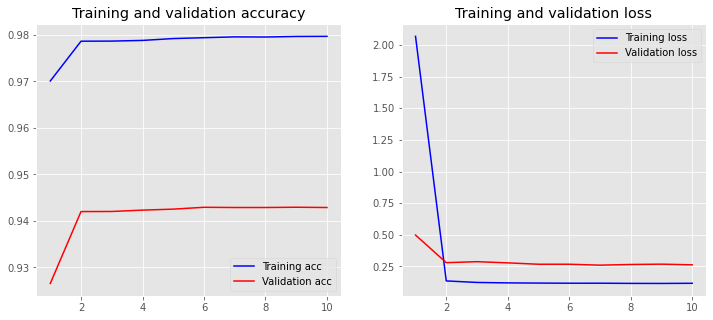

In [19]:
plot_history(history)

In [20]:
from keras.models import Sequential
from keras import layers


model = Sequential()
model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(9, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1000      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 9)                 909       
                                                                 
Total params: 22,109
Trainable params: 22,109
Non-trainable params: 0
_________________________________________________________________


In [21]:
from keras.backend import clear_session
clear_session()
history = model.fit(x_train_stacked, y_train_encoded,
                    epochs=10,
                    # verbose=False,
                    validation_data=(x_test_stacked, y_test_encoded),
                    batch_size=50)

Epoch 1/10
7193/7193 [==============================] - 7s 879us/step - loss: 0.6425 - accuracy: 0.9773 - val_loss: 0.2792 - val_accuracy: 0.9427
Epoch 2/10
7193/7193 [==============================] - 7s 925us/step - loss: 0.1294 - accuracy: 0.9795 - val_loss: 0.3125 - val_accuracy: 0.9428
Epoch 3/10
7193/7193 [==============================] - 7s 959us/step - loss: 0.1301 - accuracy: 0.9796 - val_loss: 0.2932 - val_accuracy: 0.9429
Epoch 4/10
7193/7193 [==============================] - 7s 913us/step - loss: 0.1270 - accuracy: 0.9797 - val_loss: 0.2942 - val_accuracy: 0.9432
Epoch 5/10
7193/7193 [==============================] - 7s 945us/step - loss: 0.1275 - accuracy: 0.9797 - val_loss: 0.2983 - val_accuracy: 0.9430
Epoch 6/10
7193/7193 [==============================] - 7s 919us/step - loss: 0.1243 - accuracy: 0.9797 - val_loss: 0.2963 - val_accuracy: 0.9430
Epoch 7/10
7193/7193 [==============================] - 6s 902us/step - loss: 0.1253 - accuracy: 0.9798 - val_loss: 0.2879 -

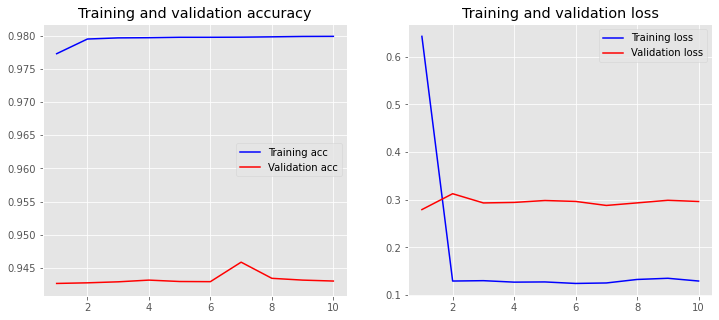

In [22]:
plot_history(history)

In [23]:
x_train_stacked.shape

(359609, 9)

In [34]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, LSTM, Flatten

model = Sequential()
model.add(LSTM(32,input_shape=(None,x_train_stacked.shape[1])))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(9))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()
model.output_shape

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 9)                 153       
                                                                 
Total params: 6,057
Trainable params: 6,057
Non-trainable params: 0
_________________________________________________________________


(None, 9)

In [35]:
# x_train_sampled = list()
# length = 200
# for i in range(0,x_train_stacked.shape[0],length):
# 	sample = np.array(x_train_stacked[i:i+length])
# 	x_train_sampled.append(sample)
# x_train_sampled = np.array(x_train_sampled)
# x_train_sampled

In [36]:
x_train_lstm = x_train_stacked.reshape((x_train_stacked.shape[0],1,x_train_stacked.shape[1]))
x_test_lstm = x_test_stacked.reshape((x_test_stacked.shape[0],1,x_test_stacked.shape[1]))
print(x_train_lstm.shape)
print(x_train_lstm)

(359609, 1, 9)
[[[28848 16623     1 ...    13     0     0]]

 [[   40    50     6 ...     0     0     0]]

 [[ 2328   116     3 ...    13     9     0]]

 ...

 [[ 1018   690     8 ...    19    37    55]]

 [[    8     9     4 ...     5     0     0]]

 [[ 1829  1262     1 ...     0     0     0]]]


In [37]:
y_train_lstm = y_train_encoded.reshape(y_train_encoded.shape[0],9)
y_test_lstm = y_test_encoded.reshape(y_test_encoded.shape[0],9)
# y_train_lstm = y_train.values.reshape(y_train.shape[0],1)
# y_test_lstm = y_test.values.reshape(y_test.shape[0],1)
print(y_train_lstm.shape)
print(y_train_lstm)

(359609, 9)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [38]:
from keras.backend import clear_session
clear_session()
history = model.fit(x_train_lstm, y_train_lstm,
                    epochs=10,
                    # verbose=False,
                    validation_data=(x_test_lstm, y_test_lstm),
                    batch_size=50)

Epoch 1/30
7193/7193 [==============================] - 12s 1ms/step - loss: 11.6023 - accuracy: 0.3082 - val_loss: 15.0373 - val_accuracy: 0.8125
Epoch 2/30
7193/7193 [==============================] - 11s 2ms/step - loss: 11.6720 - accuracy: 0.8482 - val_loss: 8.6630 - val_accuracy: 0.9414
Epoch 3/30
7193/7193 [==============================] - 11s 1ms/step - loss: 8.2039 - accuracy: 0.8310 - val_loss: 12.7086 - val_accuracy: 0.2646
Epoch 4/30
7193/7193 [==============================] - 11s 2ms/step - loss: 10.0822 - accuracy: 0.7189 - val_loss: 8.7822 - val_accuracy: 0.9368
Epoch 5/30
7193/7193 [==============================] - 11s 1ms/step - loss: 4.6483 - accuracy: 0.9777 - val_loss: 0.9456 - val_accuracy: 0.9418
Epoch 6/30
5360/7193 [=====================>........] - ETA: 2s - loss: 0.6616 - accuracy: 0.9786

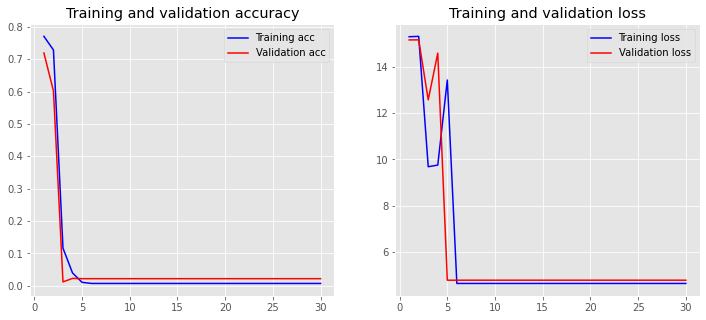

In [ ]:
plot_history(history)

In [ ]:
history.history['loss']

[15.288804054260254,
 15.305495262145996,
 9.682010650634766,
 9.752623558044434,
 13.421844482421875,
 4.6470417976379395,
 4.647039413452148,
 4.64704704284668,
 4.647044658660889,
 4.647049427032471,
 4.64705228805542,
 4.647048473358154,
 4.64704704284668,
 4.647054672241211,
 4.647046089172363,
 4.647045612335205,
 4.647048473358154,
 4.647053241729736,
 4.64704704284668,
 4.647043228149414,
 4.647053241729736,
 4.647042274475098,
 4.647044658660889,
 4.64704704284668,
 4.647045612335205,
 4.647049427032471,
 4.647051811218262,
 4.647053241729736,
 4.647047519683838,
 4.64704704284668]